In [2]:
%cd ..
%load_ext autoreload
%autoreload 2
import sensor_lib as sl

/home/jovyan/RQC-Robotics-tactile_sensor


In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from os.path import join as jn
import yaml

In [82]:
with open('params.yaml') as conf_file:
    config = yaml.safe_load(conf_file)
geo = config['env']['sen_geometry']
phys = config['env']['phys']

# generation pressure_map

In [5]:
x = geo['x_len']
y = geo['y_len']
n_pic = config['dataset']['n_sampels']
n_gaus = config['env']['presure_profile']['n_gauses']
size_kof = config['env']['presure_profile']['size_kof']
vec_mat = tf.constant(sl.get_vec_mat(x, y), dtype=tf.float32)
vec_mat = tf.reshape(vec_mat, [-1, 2])
with open(config['env']['presure_profile']['g_param_path'], 'wb+') as f:
    np.save(f, vec_mat)

2022-05-24 12:44:32.716433: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-24 12:44:32.716471: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-24 12:44:32.716498: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (0b56d4c0add5): /proc/driver/nvidia/version does not exist
2022-05-24 12:44:32.717956: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
gaus_data = sl.gen_rand_cof(n_gaus * n_pic, x, y, size_kof)
gaus_data = tf.reshape(gaus_data, [n_pic, n_gaus, 5])
pictures = sl.generate_pictures(gaus_data, vec_mat)
pictures = tf.reshape(pictures, [n_pic, x, y])

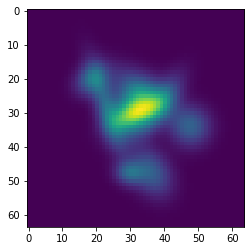

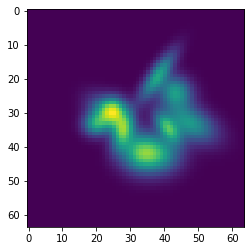

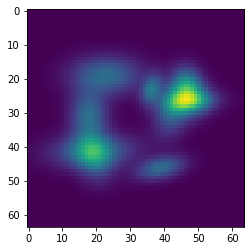

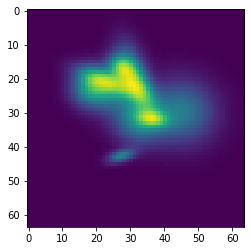

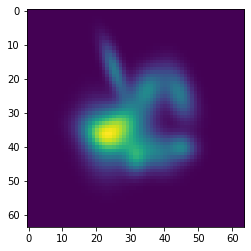

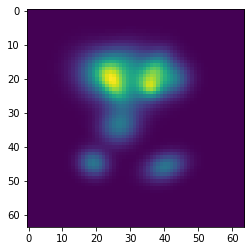

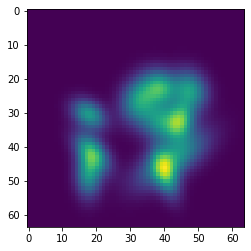

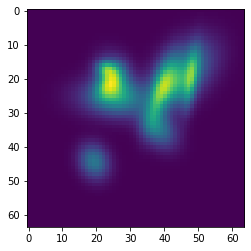

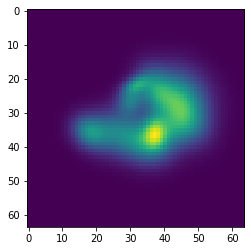

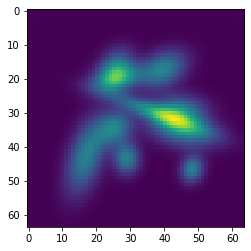

In [7]:
for i in range(10):
    plt.imshow(pictures[i])
    plt.show()

In [8]:
with open(jn(config['dataset']['pic_path'], 'one_piece.npy'), 'wb+') as f:
    np.save(f, pictures)

# counting losses in fibers (input of nerual network)

In [30]:
def sim_on_gpu2(mas, test_size, batch_size, config):

    dataset = tf.data.Dataset.from_tensor_slices(mas[0:-test_size])
    batches = dataset.batch(batch_size_preproc, drop_remainder=False)
    dataset_test = tf.data.Dataset.from_tensor_slices(mas[-test_size:])
    batches_test = dataset_test.batch(batch_size, drop_remainder=False)

    input = []
    output = []
    for batch in batches:
        input1, output1 = sl.fiber_real_sim(batch, config)
        input1 = input1[:, ::n_del, :]
        input1 = tf.tile(input1, [1, n_del, 1])
        input.append(input1)
        output.append(output1)
    input = np.concatenate(input)
    output = np.concatenate(output)

    input_test = []
    output_test = []
    for batch in batches_test:
        input_test1, output_test1 = sl.fiber_real_sim(batch, config)
        input_test1 = input_test1[:, ::n_del, :]
        input_test1 = tf.tile(input_test1, [1, n_del, 1])
        input_test.append(input_test1)
        output_test.append(output_test1)
    input_test = np.concatenate(input_test)
    output_test = np.concatenate(output_test)
    return input, output, input_test, output_test

In [31]:
    size = None
    max_possible_size = config['sim']['max_possible_size']
    test_size = config['sim']['test_size']
    batch_size = config['sim']['batch_size']
    n_del = geo['n_spl']
    mas = np.load(jn(config['dataset']['pic_path'],'one_piece.npy'), mmap_mode='r')
    if size == None:
        size = min(mas.shape[0], max_possible_size)
    if test_size == 'None':
        test_size = int(size / 10)
    mas = mas[0:size]
    mas = mas.astype('float32')

In [32]:
size

15

In [33]:
test_size

1

In [34]:
mas.shape

(15, 64, 64)

In [59]:
input, output, input_test, output_test = sim_on_gpu2(mas,
                                                     test_size,
                                                     batch_size,
                                                     config=config)

# defining nerual network for decoding and fitting it

In [72]:
input_shape = input.shape
output_shape = output.shape

In [68]:
input_shape

(64, 4)

In [69]:
output_shape

(64, 64)

In [74]:
tr = config['train']

In [75]:
model = sl.SensorNN5S_norm_deep(input_shape, output_shape)
model.build(input_shape)
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(tr['lerning_rate']),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])
model_name = 'SensorNN5S_norm_deep'

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 4)]      0           []                               
                                                                                                  
 reshape_11 (Reshape)           (None, 64, 4, 1)     0           ['input_2[0][0]']                
                                                                                                  
 Conv_1.1 (Conv2D)              (None, 64, 4, 8)     32          ['reshape_11[0][0]']             
                                                                                                  
 MaxPool_1.1 (MaxPooling2D)     (None, 32, 4, 8)     0           ['Conv_1.1[0][0]']               
                                                                                            

In [77]:
# model.fit(dataset_b, epochs=n_epochs, verbose=1)
model.fit(input, output, epochs=tr['n_epochs'], verbose=1)

Epoch 1/20
1/1 [==============================] - 1s 863ms/step - loss: 0.2465 - accuracy: 0.0089
Epoch 2/20
1/1 [==============================] - 0s 40ms/step - loss: 0.2461 - accuracy: 0.0089
Epoch 3/20
1/1 [==============================] - 0s 55ms/step - loss: 0.2455 - accuracy: 0.0089
Epoch 4/20
1/1 [==============================] - 0s 51ms/step - loss: 0.2450 - accuracy: 0.0100
Epoch 5/20
1/1 [==============================] - 0s 56ms/step - loss: 0.2445 - accuracy: 0.0100
Epoch 6/20
1/1 [==============================] - 0s 50ms/step - loss: 0.2439 - accuracy: 0.0112
Epoch 7/20
1/1 [==============================] - 0s 50ms/step - loss: 0.2434 - accuracy: 0.0112
Epoch 8/20
1/1 [==============================] - 0s 61ms/step - loss: 0.2428 - accuracy: 0.0112
Epoch 9/20
1/1 [==============================] - 0s 60ms/step - loss: 0.2422 - accuracy: 0.0123
Epoch 10/20
1/1 [==============================] - 0s 61ms/step - loss: 0.2417 - accuracy: 0.0134
Epoch 11/20
1/1 [===========

In [78]:
model.save(jn(tr['models_path'], model_name + '.nn'))

INFO:tensorflow:Assets written to: models/deep_model.nn/assets


INFO:tensorflow:Assets written to: models/deep_model.nn/assets


# evoluate model on don't seen data

In [79]:
model = tf.keras.models.load_model(jn(tr['models_path'], model_name + '.nn'))

In [80]:
model.evaluate(input_test, output_test)

1/1 [==============================] - 0s 216ms/step - loss: 0.2813 - accuracy: 0.0156


[0.28130730986595154, 0.015625]

In [81]:
predictions = model.predict(input_test)
predictions.shape

1/1 [==============================] - 0s 151ms/step


(1, 64, 64)

# saving resalts

In [85]:
ev = config['evaluate']

In [88]:
with open(jn(ev['pred_path'], 'pred.npy'), 'wb') as f:
    np.save(f, predictions)
with open(jn(ev['pred_path'], 'true.npy'), 'wb') as f:
    np.save(f, output_test)

# look on resalts

In [90]:
with open(jn(ev['pred_path'], 'pred.npy'), 'rb') as f:
    predictions = np.load(f)
with open(jn(ev['pred_path'], 'true.npy'), 'rb') as f:
    output_test = np.load(f)

len=  1


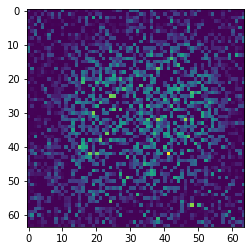

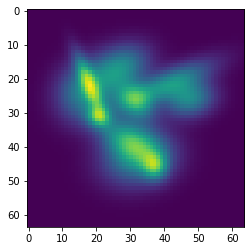

In [92]:
print('len= ', len(predictions))
N = 0  # number of exampel
plt.imshow(predictions[N])
plt.show()
plt.imshow(output_test[N])
plt.show()